In [1]:
import cv2
import numpy as np
import seaborn as sns
from tqdm import tqdm

from robust_line_based_estimator.datasets.phototourism import PhotoTourism
from robust_line_based_estimator.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.evaluation import evaluate_R_t
from robust_line_based_estimator.visualization import (plot_images, plot_lines, plot_color_line_matches,
                                                       plot_vp, plot_keypoints, plot_matches)
import pygcransac
import pyprogressivex

In [2]:
def verify_pyprogressivex(img, lines_segments, threshold = 2.0):     

    lines = []
    weights = []
    for i in range(lines_segments.shape[0]):
        p0 = lines_segments[i,0]
        p1 = lines_segments[i,1]
        len = np.linalg.norm(p1 - p0)
        lines.append([p0[0], p0[1], p1[0], p1[1]])
        weights.append(len)

    lines = np.array(lines)
    weights = np.array(weights)    

    vanishing_points, labeling = pyprogressivex.findVanishingPoints(
        np.ascontiguousarray(lines), 
        np.ascontiguousarray(weights), 
        img.shape[1], img.shape[0], 
        threshold = threshold,
        conf = 0.99,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 1.0,
        maximum_tanimoto_similarity = 1.0,
        max_iters = 1000,
        minimum_point_number = 5,
        maximum_model_number = -1,
        sampler_id = 0,
        scoring_exponent = 1.0,
        do_logging = False)    
    return vanishing_points, labeling


def find_homography_points(lines0, lines1, img1_size, img2_size, threshold = 3.0,
                           confidence = 0.5, minimum_point_number = 10):
    if lines0.shape[0] != lines1.shape[0]:
        print("The number of line segments do not match.")
        return

    line_number = lines0.shape[0]
    correspondences = []

    for i in range(line_number):
        correspondences.append([lines0[i][0][0], lines0[i][0][1], lines1[i][0][0], lines1[i][0][1]])
        correspondences.append([lines0[i][1][0], lines0[i][1][1], lines1[i][1][0], lines1[i][1][1]])
    correspondences = np.array(correspondences).astype(np.float64)
    
    homographies, labeling = pyprogressivex.findHomographies(
        np.ascontiguousarray(correspondences), 
        img1_size[1], img1_size[0], 
        img2_size[1], img2_size[0],
        threshold = threshold,
        conf = confidence,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 200.0,
        maximum_tanimoto_similarity = 0.4,
        max_iters = 1000,
        minimum_point_number = minimum_point_number,
        maximum_model_number = 10,
        sampler_id = 3,
        do_logging = False)

    model_number = max(labeling)    
    line_labeling = []
    for i in range(line_number):
        idx = 2 * i

        if labeling[idx] == labeling[idx + 1]: 
            line_labeling.append(labeling[idx])
        else:
            line_labeling.append(model_number)

    line_labeling = np.array(line_labeling)
    #for label in range(model_number):
    #    inliers = [index for index, element in enumerate(line_labeling) if element == label]
    #    print(len(inliers))
    #    if len(inliers) < minimum_point_number:
    #        line_labeling[inliers] = model_number

    return homographies, line_labeling


def normalize_keypoints(keypoints, K):
    '''Normalize keypoints using the calibration data.'''
    C_x = K[0, 2]
    C_y = K[1, 2]
    f_x = K[0, 0]
    f_y = K[1, 1]
    keypoints = (keypoints - np.array([[C_x, C_y]])) / np.array([[f_x, f_y]])
    return keypoints


def find_relative_pose_from_points(kp_matches, kp_scores, K1, K2):
    # Select the points with lowest ratio score
    good_matches = kp_scores < 0.8
    pts1 = kp_matches[good_matches, :2]
    pts2 = kp_matches[good_matches, 2:]
    
    # Normalize KP
    p1n = normalize_keypoints(pts1, K1)
    p2n = normalize_keypoints(pts2, K2)
    
    # Find the essential matrix with OpenCV RANSAC
    E, inl_mask = cv2.findEssentialMat(p1n, p2n, np.eye(3), cv2.RANSAC, 0.999, 1e-3)
    inl_mask = np.array(inl_mask)[:, 0].astype(bool)
    pts1_inl = pts1[inl_mask]
    pts2_inl = pts2[inl_mask]
    
    # Obtain the corresponding pose
    if E.size > 0:
        _, R, t, _ = cv2.recoverPose(E, p1n, p2n)
    else:
        raise ValueError("Unable to recover a pose.")
    
    return R, t, pts1_inl, pts2_inl

## Relative pose estimation on PhotoTourism

In [3]:
# Initialize the dataset
dataset = PhotoTourism(root_dir="/home/remi/Documents/datasets/RANSAC-Tutorial-Data/", split='val', load_points=True)
dataloader = dataset.get_dataloader()

# Initialize the line method
line_method = 'lsd'  # 'lsd' or 'SOLD2' supported for now
if line_method == 'sold2':
    # SOLD2 matcher
    conf = {
        'sold2': {
            'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
            'device': 'cpu'
        }
    }
    sold2_matcher = LineMatcher(line_detector='sold2', line_matcher='sold2', conf=conf)
else:
    # LSD+LBD matcher
    lsd_lbd_matcher = LineMatcher(line_detector='lsd', line_matcher='lbd')

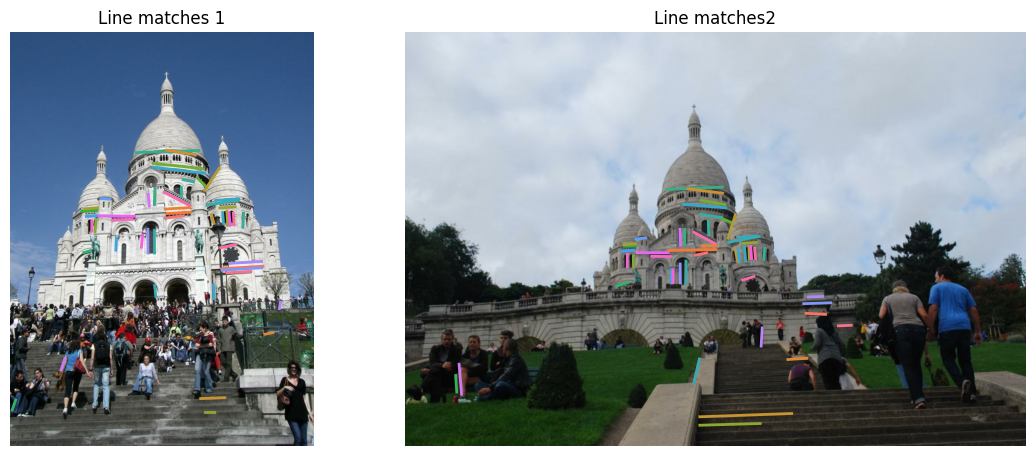

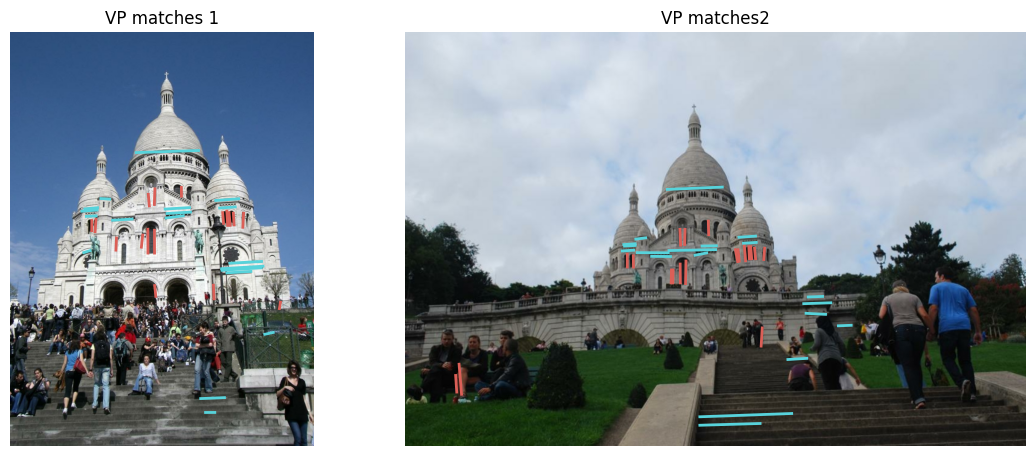

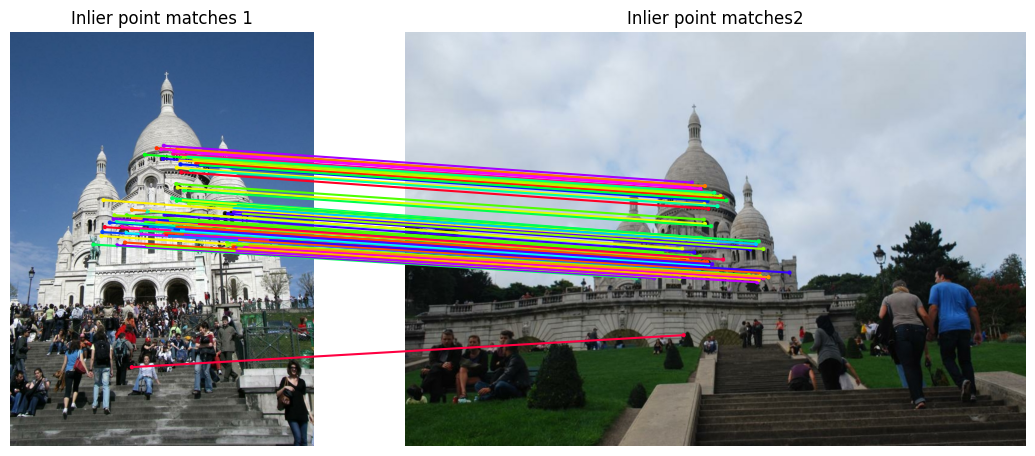

In [5]:
# Check that the evaluation tool works with a few visualizations
num_images = 1
for i, data in enumerate(dataloader):
    if i >= num_images:
        break

    img1 = data["img1"]
    img2 = data["img2"]
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    gt_R_1_2 = data["R_1_2"]
    gt_T_1_2 = data["T_1_2"]
    K1 = data["K1"]
    K2 = data["K2"]
    
    # Detect, describe and match lines
    if line_method == 'sold2':
        line_feat1 = sold2_matcher.detect_and_describe_lines(gray_img1)
        line_feat2 = sold2_matcher.detect_and_describe_lines(gray_img2)
        _, m_lines1, m_lines2 = sold2_matcher.match_lines(gray_img1, gray_img2, line_feat1, line_feat2)
    else:
        line_feat1 = lsd_lbd_matcher.detect_and_describe_lines(gray_img1)
        line_feat2 = lsd_lbd_matcher.detect_and_describe_lines(gray_img2)
        _, m_lines1, m_lines2 = lsd_lbd_matcher.match_lines(gray_img1, gray_img2, line_feat1, line_feat2)
        
    # Compute and match VPs
    m_lines1_inl = m_lines1[:, :, [1, 0]]
    vp1, label1 = verify_pyprogressivex(gray_img1, m_lines1_inl, threshold=1.5)
    m_lines2_inl = m_lines2[:, :, [1, 0]]
    vp2, label2 = verify_pyprogressivex(gray_img2, m_lines2_inl, threshold=1.5)
    m_vp1, m_label1, m_vp2, m_label2 = vp_matching(vp1, label1, vp2, label2)
    
    # Compute homographies from lines
#     homographies, labels = find_homography_points(m_lines1[:, :, [1, 0]], m_lines2[:, :, [1, 0]],
#                                                   gray_img1.shape, gray_img2.shape)
#     n_homographies = max(labels)
#     colors = sns.color_palette('husl', n_colors=n_homographies + 1)

    # Get the relative pose from points here
    pred_R_1_2, pred_T_1_2, pts1_inl, pts2_inl = find_relative_pose_from_points(data["kp_matches"], data["kp_scores"], K1, K2)
    
    # Display the matched lines, VPs, and homographies
    plot_images([img1, img2], ['Line matches 1', 'Line matches2'])
    plot_color_line_matches([m_lines1[:, :, [1, 0]], m_lines2[:, :, [1, 0]]])
    plot_images([img1, img2], ['VP matches 1', 'VP matches2'])
    plot_vp([m_lines1_inl, m_lines2_inl], [m_label1, m_label2])
#     plot_images([img1, img2], ['H matches 1', 'H matches2'])
#     for label in range(n_homographies):
#         inliers = [index for index, element in enumerate(labels) if element == label]
#         plot_color_line_matches([m_lines1[inliers][:, :, [1, 0]], m_lines2[inliers][:, :, [1, 0]]], color = colors[label])
    plot_images([img1, img2], ['Inlier point matches 1', 'Inlier point matches2'])
    plot_matches(pts1_inl, pts2_inl)

In [7]:
pose_errors = []
for data in tqdm(dataloader):
    img1 = data["img1"]
    img2 = data["img2"]
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    gt_R_1_2 = data["R_1_2"]
    gt_T_1_2 = data["T_1_2"]
    K1 = data["K1"]
    K2 = data["K2"]

    # Detect, describe and match lines
    if line_method == 'sold2':
        line_feat1 = sold2_matcher.detect_and_describe_lines(gray_img1)
        line_feat2 = sold2_matcher.detect_and_describe_lines(gray_img2)
        _, m_lines1, m_lines2 = sold2_matcher.match_lines(gray_img1, gray_img2, line_feat1, line_feat2)
    else:
        line_feat1 = lsd_lbd_matcher.detect_and_describe_lines(gray_img1)
        line_feat2 = lsd_lbd_matcher.detect_and_describe_lines(gray_img2)
        _, m_lines1, m_lines2 = lsd_lbd_matcher.match_lines(gray_img1, gray_img2, line_feat1, line_feat2)

    # Compute and match VPs
    m_lines1_inl = m_lines1[:, :, [1, 0]]
    vp1, label1 = verify_pyprogressivex(gray_img1, m_lines1_inl, threshold=1.5)
    m_lines2_inl = m_lines2[:, :, [1, 0]]
    vp2, label2 = verify_pyprogressivex(gray_img2, m_lines2_inl, threshold=1.5)
    m_vp1, m_label1, m_vp2, m_label2 = vp_matching(vp1, label1, vp2, label2)

    # Compute homographies from lines
#     homographies, labels = find_homography_points(m_lines1[:, :, [1, 0]], m_lines2[:, :, [1, 0]],
#                                                   gray_img1.shape, gray_img2.shape)

    # Evaluate the relative pose
    # TODO: compute the relative pose from VP and homography association
    pred_R_1_2, pred_T_1_2, pts1_inl, pts2_inl = find_relative_pose_from_points(data["kp_matches"], data["kp_scores"], K1, K2)
    pose_errors.append(max(evaluate_R_t(gt_R_1_2, gt_T_1_2, pred_R_1_2, pred_T_1_2)))

print("Average pose error:", np.mean(pose_errors))

100%|██████████| 9900/9900 [03:55<00:00, 42.05it/s] 

Average pose error: 0.18246648212400263
